In [1]:
# how to change jupyter-notebook and plotting theme. 

#!jt -l    lists possible theme options
#!jt -t <theme_option> -T -N -kl
#    Toolbar Visible -T
#    Name and Logog Visible -N
#    Kernel Logo Visible -kl
# jtplot.style(theme='chesterish', 
# context='notebook', ticks=True, grid=False)
#     changes plotting theme
# !jt -r    resets to default theme. 


#import jupyterthemes as jt
#from jupyterthemes import jtplot
#!jt -l
#!jt -t chesterish -T -N -kl
#jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)
#!jt -r

# TFP version that's compatible with TensorFlow version 2.2
#! pip install tensorflow_probability==0.10.0
# tqdm needed for custom progress bar in fit method
#! pip install tqdm

In [2]:
import sys
sys.path.append("../..")

import logging
logging.getLogger('tensorflow').disabled = True

import numpy as np
import sklearn.datasets as skd
# visualization
import matplotlib.pyplot as plt
from scipy.stats import kde
#progress bar
import tqdm
#smoothing loss history
from scipy.ndimage.filters import gaussian_filter1d
# tf and friends
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import tensorflow.keras.layers as layers
# FFJORD transport_nets keras model
from transport_nets.models import FFJORD

tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions

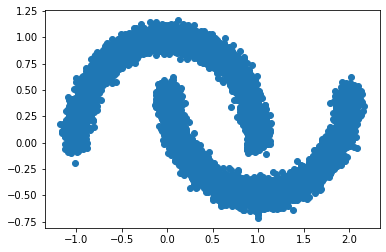

In [3]:
DATASET_SIZE = 10000 
BATCH_SIZE = 500 

moons = skd.make_moons(n_samples=DATASET_SIZE, noise=.06)[0]

moons_ds = tf.data.Dataset.from_tensor_slices(moons.astype(np.float32))
moons_ds = moons_ds.prefetch(tf.data.experimental.AUTOTUNE)
moons_ds = moons_ds.cache()
moons_ds = moons_ds.shuffle(DATASET_SIZE)
moons_ds = moons_ds.batch(BATCH_SIZE)

plt.scatter(moons[:, 0], moons[:, 1])
plt.show()

In [4]:
OUTPUT_DIM = 2
NUM_BIJECTORS = 2
NEURON_LIST = [100,100]

LR = 1e-2
opt = tf.keras.optimizers.Adam(LR, epsilon=1e-08)
NUM_EPOCHS = 50
ffjord = FFJORD(OUTPUT_DIM,NUM_BIJECTORS,NEURON_LIST)
ffjord.compile(opt)
loss_history = ffjord.fit_custom(moons_ds,NUM_EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


loss: 0.535 : 100%|██████████| 50/50 [06:49<00:00,  8.20s/it]


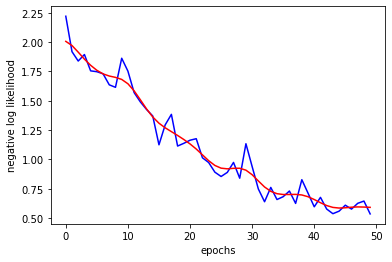

In [5]:
ysmoothed = gaussian_filter1d(loss_history, sigma=2)
plt.plot(loss_history,'b')
plt.plot(ysmoothed, color = 'r')
plt.xlabel('epochs')
plt.ylabel('negative log likelihood');

In [ ]:
T = tf.constant(moons[::10],dtype=tf.float32)
N_samps = T.shape[0]
X = ffjord.sample(N_samps)

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].scatter(T[:,0],T[:,1],alpha=0.5,label='target')
ax[0].scatter(X[:,0],X[:,1],alpha=0.5,label='ffjord sample')
ax[0].legend()

R = ffjord.inverse(T)
Normal = tf.random.normal([R.shape[0],OUTPUT_DIM])
ax[1].scatter(Normal[:,0],Normal[:,1],alpha=0.5,label='standard normal')
ax[1].scatter(R[:,0],R[:,1],alpha=0.5,label='target inverse')
ax[1].legend();